In [1]:
#DO NOT EDIT THIS CELL
#Run this cell to install required packages.

!pip install ipywidgets

#Next, click the jupyter icon, select the STARTER file, and shutdown.
#Then, return to the STARTER file. 

Defaulting to user installation because normal site-packages is not writeable


In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset
import os
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [14]:
best_loss = 10 ** 9
patience_threshold = 10
num_patience = 0
epsilon = 0.00001
mini_batch_size = 64
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
root_dir = "root"
valid_ratio = 0.2


# Define transforms
transform = transforms.ToTensor()
# Create training set and define training dataloader
training_data = datasets.MNIST(root = root_dir, train=True, download=True, transform=transform)

# Split training set into validation set & training set with normalization
num_train = len(training_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_ratio * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(training_data, batch_size = mini_batch_size, sampler=train_sampler, pin_memory = True)
validation_loader = DataLoader(training_data, batch_size = mini_batch_size, sampler=valid_sampler, pin_memory = True)

# Create test set and define test dataloader
test_data = datasets.MNIST(root = root_dir, train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size = mini_batch_size, shuffle = True, pin_memory = True)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I chose a normalization transform because the normalization of inputs helps to learn more flexibly by making the network considers all inputs to be in a similar range.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [15]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

8


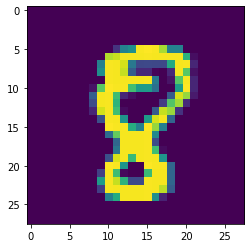

8


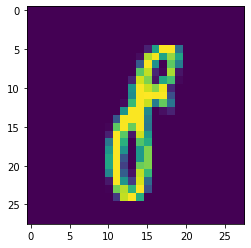

5


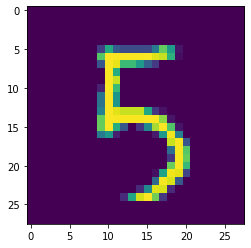

2


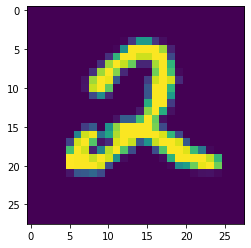

8


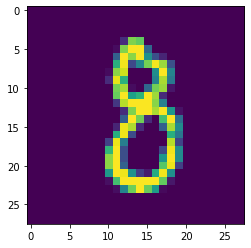

In [5]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [16]:
# Build my NN
class MNIST_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.output = F.softmax
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x,1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.output(self.fc3(x), dim=1)
        return x

class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 2, 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 16, 2, 1, padding = 1)
        self.fc1 = nn.Linear(28*28, 10)
        self.activation = F.relu

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.activation(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.activation(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [17]:
model = MNIST_CNN()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [18]:
train_loss_history = list()
val_loss_history = list()
train_acc_history = list()
val_acc_history = list()

num_epochs = 15
stopped_epoch = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)


        # Zero out the gradients of the optimizer
        optimizer.zero_grad()

        # Get the outputs of your model and compute your loss
        outputs = model(inputs)
        loss = criterion(outputs, labels)


        # Compute the loss gradient using the backward method and have the optimizer take a step
        loss.backward()
        optimizer.step()

        # Compute the accuracy and print the accuracy and loss
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()

    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader)/mini_batch_size * 100:.2f}% training loss: {train_loss/len(train_loader)/mini_batch_size:.5f}')
    train_loss_history.append(train_loss/len(train_loader)/mini_batch_size)
    train_acc_history.append(train_correct/len(train_loader)/mini_batch_size*100)


    val_loss = 0.0
    val_correct = 0
    model.eval()
    for inputs, labels in validation_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()

    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(validation_loader)/mini_batch_size * 100:.2f}% validation loss: {val_loss/len(validation_loader)/mini_batch_size:.5f}')
    val_loss_history.append(val_loss/len(validation_loader)/mini_batch_size)
    val_acc_history.append(val_correct/len(validation_loader)/mini_batch_size*100)

    # logic for early stopping
    if best_loss - val_loss/len(validation_loader) < epsilon:
        num_patience += 1
        print(f'Early stopping counter: {num_patience} out of {patience_threshold}')

        if num_patience >= patience_threshold:
            stopped_epoch = epoch
            break

    else:
        best_loss = val_loss/len(validation_loader)/mini_batch_size
        num_patience = 0
        save_path = "root/CNN_test_" + "epoch_" + str(epoch) + ".pt"
        torch.save(model.state_dict(), save_path)

Epoch 1 training accuracy: 85.98% training loss: 0.00726
Epoch 1 validation accuracy: 93.54% validation loss: 0.00328
Epoch 2 training accuracy: 94.94% training loss: 0.00263
Epoch 2 validation accuracy: 96.00% validation loss: 0.00196
Early stopping counter: 1 out of 10
Epoch 3 training accuracy: 96.38% training loss: 0.00181
Epoch 3 validation accuracy: 96.64% validation loss: 0.00160
Early stopping counter: 2 out of 10
Epoch 4 training accuracy: 96.98% training loss: 0.00152
Epoch 4 validation accuracy: 97.11% validation loss: 0.00140
Early stopping counter: 3 out of 10
Epoch 5 training accuracy: 97.39% training loss: 0.00131
Epoch 5 validation accuracy: 97.30% validation loss: 0.00129
Early stopping counter: 4 out of 10
Epoch 6 training accuracy: 97.68% training loss: 0.00118
Epoch 6 validation accuracy: 97.30% validation loss: 0.00124
Early stopping counter: 5 out of 10
Epoch 7 training accuracy: 97.85% training loss: 0.00109
Epoch 7 validation accuracy: 97.58% validation loss: 0.

Plot the training loss (and validation loss/accuracy, if recorded).

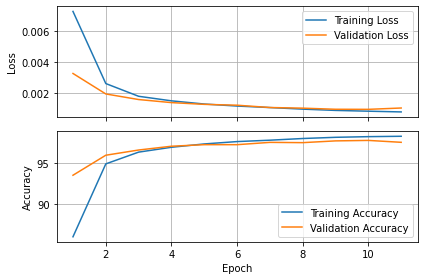

In [19]:
ax1 = plt.subplot(2,1,1)
if stopped_epoch == 0:
    x1 = list(range(1,num_epochs + 1))
    save_path = "root/CNN_test_" + "epoch_" + str(epoch) + ".pt"
    torch.save(model.state_dict(), save_path)

else:
    x1 = list(range(1, stopped_epoch + 2))
plt.plot(x1, train_loss_history, label="Training Loss")
plt.plot(x1, val_loss_history, label="Validation Loss")
plt.ylabel('Loss')
plt.xticks(visible=False)
plt.legend()
plt.grid()

ax2 = plt.subplot(2,1,2)
plt.plot(x1, train_acc_history, label="Training Accuracy")
plt.plot(x1, val_acc_history, label="Validation Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()

plt.tight_layout()
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [20]:
# Test the network
model.eval()
test_correct = 0
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)
    test_correct += (preds == labels).sum().item()

print(f'Test accuracy: {test_correct/len(test_loader)/mini_batch_size*100:.2f}%')

Test accuracy: 97.42%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [ ]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
save_path = "root/CNN_test_" + "epoch_" + str(15) + ".pt"
torch.save(model.state_dict(), save_path)